**Dados de 1.997 clientes que tomaram empréstimos em um determinado banco (Não informado).**


1. i#clientid = ID do cliente.
2. income = Renda do cliente.
3. age = Idade do cliente.
4. loan = Valor do empréstimo.
5. c#default = 0: Cliente pagou o empréstimo | 1: Cliente não pagou.








**Desenvolvi os modelos com 3 estimadores de famílias diferentes para modelagem - KNN, XGBoost e Otimização Bayesiana e 1 rede neural - Keras**

# **Importando e analisando os dados**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, datetime
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost.sklearn import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

%matplotlib inline

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('credit_data.csv')
df

,i#clientid,income,age,loan,c#default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1
...,...,...,...,...,...
1995,1996,59221.044874,48.518179,1926.729397,0
1996,1997,69516.127573,23.162104,3503.176156,0
1997,1998,44311.449262,28.017167,5522.786693,1
1998,1999,43756.056605,63.971796,1622.722598,0


**Verificando se há dados nulos**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   i#clientid  2000 non-null   int64  
 1   income      2000 non-null   float64
 2   age         1997 non-null   float64
 3   loan        2000 non-null   float64
 4   c#default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.2 KB


**Eliminando os dados nulos, já que são poucos, nao irá fazer diferença.**

In [ ]:
df.dropna(inplace=True)

**Verificando se há dados duplicados.**

In [ ]:
df.duplicated().value_counts()

False    1997
dtype: int64

**Coluna Target: c#defaul => 0 = Pagou o empréstimo | 1 = Não pagou o empréstimo**

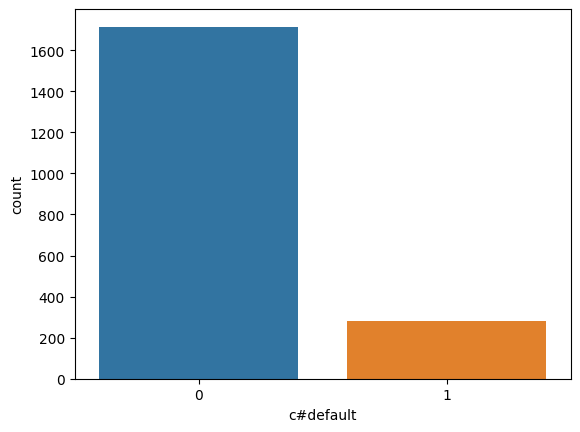

In [ ]:
import seaborn as sns
sns.countplot(x=df['c#default']);

**Descrevendo o desvio padrão e os valores dos quartis.**

In [ ]:
df.describe()

,i#clientid,income,age,loan,c#default
count,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000
mean,1001.956935,45333.864334,40.807559,4445.487716,0.141713
std,576.702206,14325.131177,13.624469,3046.792457,0.348842
min,1.000000,20014.489470,-52.423280,1.377630,0.000000
25%,503.000000,32804.904487,28.990415,1936.813257,0.000000
50%,1002.000000,45788.747100,41.317159,3977.287432,0.000000
75%,1501.000000,57787.565659,52.587040,6440.861434,0.000000
max,2000.000000,69995.685578,63.971796,13766.051239,1.000000


**Correlação entre as variáveis.**

In [ ]:
df.corr()

,i#clientid,income,age,loan,c#default
i#clientid,1.000000,0.039133,-0.014704,0.018358,-0.021217
income,0.039133,1.000000,-0.033687,0.441539,0.002222
age,-0.014704,-0.033687,1.000000,0.002309,-0.429759
loan,0.018358,0.441539,0.002309,1.000000,0.377169
c#default,-0.021217,0.002222,-0.429759,0.377169,1.000000


<Axes: >

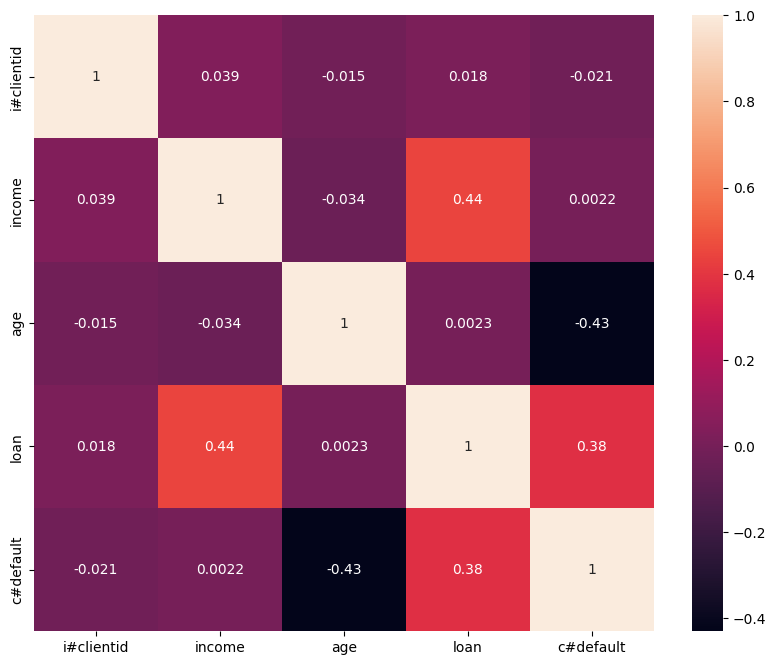

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True)

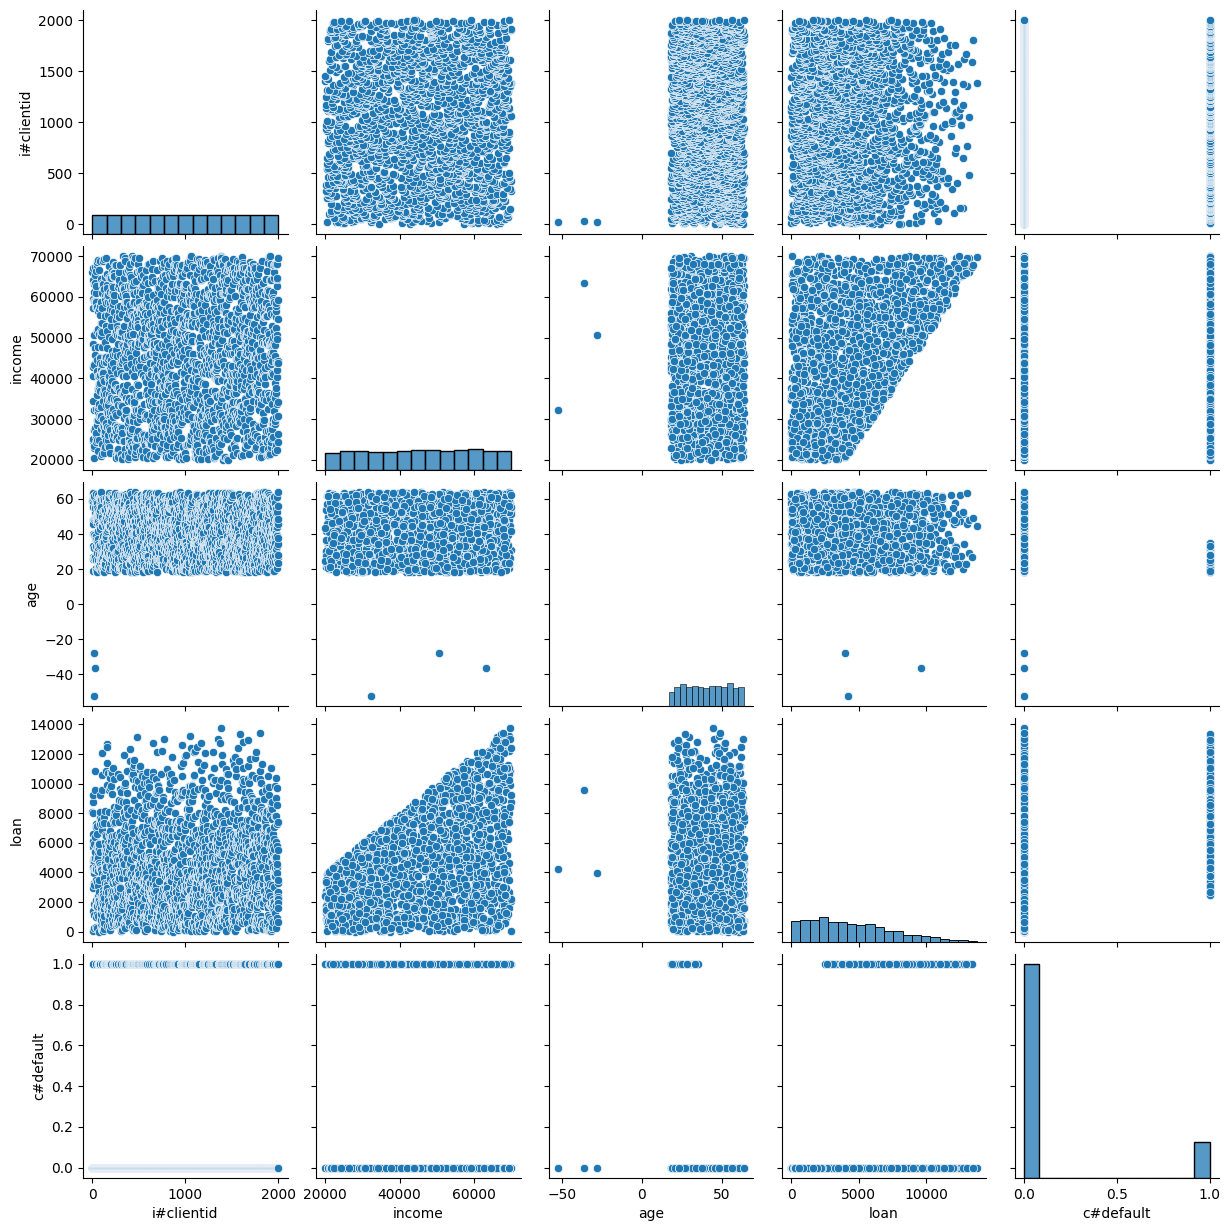

In [ ]:
sns.pairplot(df);

# **KNN Classifier**

**O KNN Classifier é um classificador onde o aprendizado é baseado “no quão similar” é um dado (um vetor) do outro.**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
df

,i#clientid,income,age,loan,c#default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1
...,...,...,...,...,...
1995,1996,59221.044874,48.518179,1926.729397,0
1996,1997,69516.127573,23.162104,3503.176156,0
1997,1998,44311.449262,28.017167,5522.786693,1
1998,1999,43756.056605,63.971796,1622.722598,0


**Vamos escalonar para que não cause nenhum viés no resultado.**

In [ ]:
ssc = StandardScaler()

ssc.fit(df[["income", "age", "loan"]])
h= ssc.transform(df[["income", "age", "loan"]])
df[["income", "age", "loan"]] = h

In [ ]:
df

,i#clientid,income,age,loan,c#default
0,1,1.453898,1.336861,1.201907,0
1,2,-0.762398,0.536639,0.695744,0
2,3,0.836733,1.637207,1.173812,0
3,4,-0.183244,0.362998,0.544366,0
4,5,1.509532,-1.631534,1.419754,1
...,...,...,...,...,...
1995,1996,0.969671,0.566081,-0.826899,0
1996,1997,1.688523,-1.295454,-0.309357,0
1997,1998,-0.071390,-0.939016,0.353673,1
1998,1999,-0.110170,1.700619,-0.926703,0


**Separando o que é variável de target e também os dados de treinos e dados de teste. Já que contém poucos dados, vamos colocar para treinar 90% dos dados e 10% para teste.**

In [ ]:
X = df.drop(columns=["i#clientid", "c#default"])
y = df["c#default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13, stratify=y)

In [ ]:
neigh = KNeighborsClassifier()

**Fazendo a grade de parâmetros do KNN**

In [ ]:
param_grid_knn = {"weights" : ["uniform", "distance"],
                 "metric" : ["manhattan", "euclidean"],
                 "n_neighbors" : range(2, 21)}

In [ ]:
splitter = StratifiedKFold(n_splits=10, shuffle=True)

**Estruturando o GridSearch**

In [ ]:
model_knn = GridSearchCV(estimator=neigh,
                       param_grid=param_grid_knn,
                       scoring="accuracy", 
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

**Rodando o modelo...**

In [ ]:
model_knn.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': range(2, 21),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=10)

**Conhecendo os melhores parâmetros achados...**

In [ ]:
model_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}

**Vemos abaixo que deu uma acurácia de 83% na base de teste , em breve vamos tentar melhorar fazendo com outros modelos**

**Deu um overfiting nos dados de teino, mas nos dados de teste bateu 98% de acurácia!**


Métricas de avaliação de treino:
[[1542    0]
 [   0  255]]


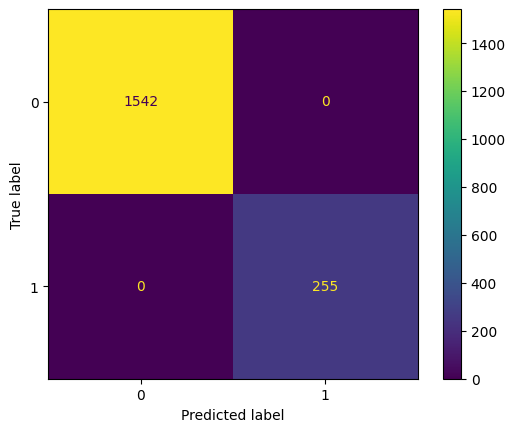

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1542
           1       1.00      1.00      1.00       255

    accuracy                           1.00      1797
   macro avg       1.00      1.00      1.00      1797
weighted avg       1.00      1.00      1.00      1797


Métricas de avaliação de teste:
[[172   0]
 [  3  25]]


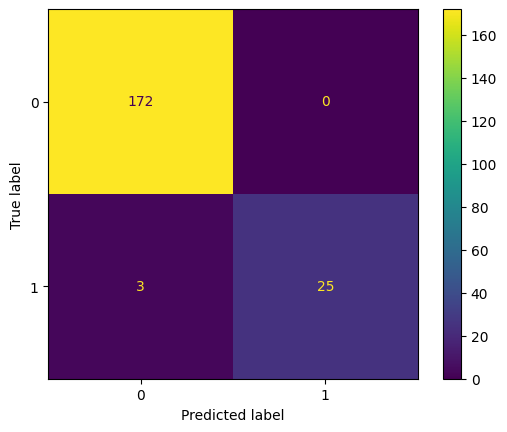

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       172
           1       1.00      0.89      0.94        28

    accuracy                           0.98       200
   macro avg       0.99      0.95      0.97       200
weighted avg       0.99      0.98      0.98       200



In [ ]:
### ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = model_knn.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = model_knn.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

**Probabilidade de sair cada diagnóstico:**

In [ ]:
probas = model_knn.predict_proba(X_test)

**Primeira coluna é para 0: Probabilidade de pagar o valor**

**Segunda coluna é para o número 1: Probabilidade de não pagar o valor.**

In [ ]:
probas

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.81810725, 0.18189275],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.37525544, 0.62474456],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.71828471, 0.28171529],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.56395918, 0.43604082],
       [1.        , 0.        ],
       [0.89338617, 0.10661383],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.94588825, 0.05411175],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.60505637, 0.39494363],
       [1.        , 0.        ],
       [1.

**Vamos criar uma tabela com os resultados da predição em comparação às existentes.**

In [ ]:
tabela_knn_ob = pd.DataFrame()

In [ ]:
tabela_knn_ob["Amostra existente"] = y_test

In [ ]:
tabela_knn_ob["Predição"] = y_pred_test

In [ ]:
tabela_knn_ob

,Amostra existente,Predição
54,0,0
599,0,0
619,0,0
1041,0,0
995,0,0
...,...,...
1192,0,0
1394,0,0
1598,0,0
1968,0,0


**Salvando a tabela**

In [ ]:
tabela_knn_ob.to_csv("16_tabela_comparação.csv")

**Salvando o modelo...**

In [ ]:
import joblib

In [ ]:
joblib.dump(model_knn, 'knn_modelo.pkl')

['knn_modelo.pkl']

In [ ]:
knn_modelo = joblib.load('knn_modelo.pkl')

# **XGBOOST CLASSIFIER**

**O XGBoost é um algoritmo de aprendizado de máquina, baseado em árvore de decisão e que utiliza uma estrutura de Gradient boosting.**

**Já escalonamos os dados no KNN, então vamos seguir diante.**

In [ ]:
X = df.drop(columns=["i#clientid", "c#default"])
y = df["c#default"]

#Coloquei 90% para os dados de treino, semelhante ao KNN, pois há poucos dados. E estou usando o parâmetro para estratificar, pois os dados do target não estão balançeados.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13, stratify=y)

In [ ]:
xgbc = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

**Fazendo a grade de parâmetros do XGBoost Classifier**

In [ ]:
params_grid_xgbc = {"n_estimators": [2000, 5000],
                   "max_depth": [1, 2, 8, 10],
                   "learning_rate": [0.001, 0.0001],
                   "colsample_bytree": [0.2],
                   "subsample": [0.8]}

In [ ]:
splitter = StratifiedKFold(n_splits=10, shuffle=True)

**Estruturando o GridSearch**

In [ ]:
model_xgbc = GridSearchCV(estimator=xgbc,
                       param_grid=params_grid_xgbc,
                       scoring="accuracy", 
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

In [ ]:
model_xgbc.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     import...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.2],
                         'learning_rate': [0.001, 0.0001],
                         'max_depth': [1, 2, 8, 10],
                         'n_estimators': [2000, 5000], 'subsample': [0.8]},
             scoring='accuracy', verbose=10)

In [ ]:
model_xgbc.best_params_

{'colsample_bytree': 0.2,
 'learning_rate': 0.001,
 'max_depth': 2,
 'n_estimators': 5000,
 'subsample': 0.8}

In [ ]:
grid_xgbr_results = pd.DataFrame(model_xgbc.cv_results_)
grid_xgbr_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,4.625942,2.097056,0.013935,0.001034,0.2,0.001,2,5000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.916667,0.927778,0.905556,0.922222,0.932961,0.921788,0.949721,0.928225,0.012738,1
1,3.445147,1.357440,0.010705,0.002782,0.2,0.001,1,5000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.927778,0.927778,0.900000,0.938889,0.944134,0.921788,0.949721,0.923786,0.016223,2
5,8.792428,0.728795,0.046009,0.000644,0.2,0.001,8,5000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.905556,0.877778,0.888889,0.883333,0.899441,0.899441,0.905028,0.897613,0.010243,3
7,10.007463,0.461025,0.060932,0.015272,0.2,0.001,10,5000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.905556,0.877778,0.888889,0.877778,0.893855,0.899441,0.899441,0.893163,0.009145,4
6,4.201807,0.951028,0.036878,0.016959,0.2,0.001,10,2000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.861111,0.872222,0.855556,0.866667,0.871508,0.860335,0.877095,0.867005,0.006222,5
4,3.692579,0.711004,0.023510,0.007393,0.2,0.001,8,2000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.861111,0.872222,0.855556,0.866667,0.865922,0.860335,0.877095,0.865891,0.006247,6
15,8.332767,0.634186,0.042583,0.011668,0.2,0.0001,10,5000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.861111,0.855556,0.855556,0.861111,0.860335,0.860335,0.860335,0.859212,0.002415,7
14,3.141502,0.651956,0.018975,0.004220,0.2,0.0001,10,2000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.855556,0.855556,0.855556,0.861111,0.860335,0.860335,0.860335,0.858656,0.002549,8
0,1.386981,0.347233,0.010131,0.006094,0.2,0.001,1,2000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.855556,0.855556,0.855556,0.855556,0.860335,0.860335,0.860335,0.858101,0.002559,9
2,1.963617,0.688446,0.010294,0.004985,0.2,0.001,2,2000,0.8,"{'colsample_bytree': 0.2, 'learning_rate': 0.0...",...,0.855556,0.855556,0.855556,0.855556,0.860335,0.860335,0.860335,0.858101,0.002559,9


**O gap do XGBoost foi menor dos dados de treino em relação aos dados de teste em relação ao KNN e não overfitou!**


Métricas de avaliação de treino:
[[1538    4]
 [ 101  154]]


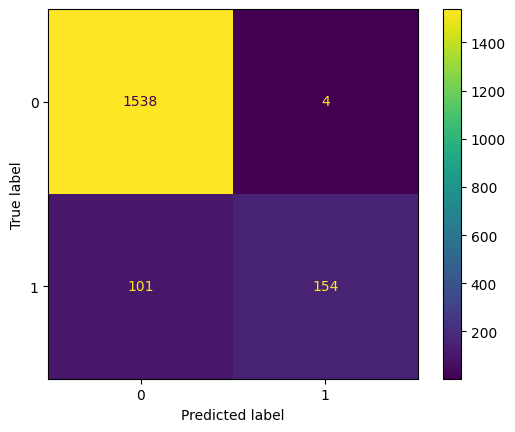

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1542
           1       0.97      0.60      0.75       255

    accuracy                           0.94      1797
   macro avg       0.96      0.80      0.86      1797
weighted avg       0.94      0.94      0.94      1797


Métricas de avaliação de teste:
[[171   1]
 [ 15  13]]


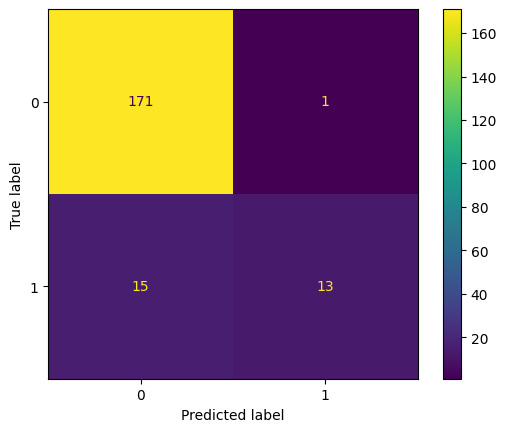

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       172
           1       0.93      0.46      0.62        28

    accuracy                           0.92       200
   macro avg       0.92      0.73      0.79       200
weighted avg       0.92      0.92      0.91       200



In [ ]:
### ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = model_xgbc.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = model_xgbc.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

In [ ]:
resultado_xgbr = df["c#default"].unique()
print(f"{resultado_xgbr}")

[0 1]


**Probabilidade de sair cada diagnóstico:**

**Primeira coluna é para 0: Probabilidade de pagar o valor**

**Segunda coluna é para o número 1: Probabilidade de não pagar o valor.**

In [ ]:
probas_xgbc = model_xgbc.predict_proba(X_test)
probas_xgbc

array([[0.98800147, 0.01199855],
       [0.9177763 , 0.08222369],
       [0.88979584, 0.11020417],
       [0.9149557 , 0.08504432],
       [0.9877659 , 0.0122341 ],
       [0.9912236 , 0.00877645],
       [0.9714711 , 0.02852894],
       [0.583274  , 0.41672602],
       [0.9866649 , 0.01333511],
       [0.88986707, 0.11013293],
       [0.6106677 , 0.3893323 ],
       [0.9904292 , 0.00957075],
       [0.3961395 , 0.6038605 ],
       [0.70946884, 0.29053113],
       [0.8963257 , 0.10367427],
       [0.700145  , 0.29985502],
       [0.983302  , 0.01669799],
       [0.6911832 , 0.30881676],
       [0.9270774 , 0.07292261],
       [0.46717542, 0.5328246 ],
       [0.64637244, 0.35362753],
       [0.9719951 , 0.0280049 ],
       [0.9079795 , 0.09202051],
       [0.8987764 , 0.10122361],
       [0.88365996, 0.11634006],
       [0.9299834 , 0.07001662],
       [0.88946855, 0.11053146],
       [0.9011012 , 0.09889881],
       [0.7889577 , 0.21104227],
       [0.9330093 , 0.06699066],
       [0.

In [ ]:
tabela_inadimplência_xgbc = pd.DataFrame()

In [ ]:
tabela_inadimplência_xgbc["Amostra existente"] = y_test

In [ ]:
tabela_inadimplência_xgbc["Predição"] = y_pred_test

In [ ]:
tabela_inadimplência_xgbc

,Amostra existente,Predição
54,0,0
599,0,0
619,0,0
1041,0,0
995,0,0
...,...,...
1192,0,0
1394,0,0
1598,0,0
1968,0,0


Salvando a tabela

In [ ]:
tabela_inadimplência_xgbc.to_csv("16-inadimplecia_xgbc.csv")

Salvando o estimador...

In [ ]:
import joblib

In [ ]:
joblib.dump(model_knn, 'xgbc_modelo.pkl')

['xgbc_modelo.pkl']

In [ ]:
knn_modelo = joblib.load('knn_modelo.pkl')

# **Otimização Bayesiana**

**Utiliza o processo gaussiano. Vamos utlizar para tentar melhorar a acurácia**.



---



---



---



In [ ]:


def pipe_inadi_credit(drop_not_features=["c#default"], col_target="c#default",
                             inputer_num_strategy="mean",
                             encoding="ordinal"):
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    '''

    X = df.drop(columns=drop_not_features)
    y = df[col_target]
    
    X_train_ob, X_test_ob, y_train_ob, y_test_ob = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy=inputer_num_strategy)),
                                  ("std", StandardScaler())])

    features_num = X_train_ob.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train_ob.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train_ob, X_test_ob, y_train_ob, y_test_ob, pre_processador

In [ ]:
X_train_ob, X_test_ob, y_train_ob, y_test_ob, pre_processador = pipe_inadi_credit(drop_not_features=["c#default"], 
                                                                            col_target="c#default",
                                                                            inputer_num_strategy="mean",
                                                                            encoding="ordinal")

In [ ]:
!pip install hyperopt
from six.moves import collections_abc
from hyperopt import hp, tpe, fmin, Trials, space_eval

**Vamos utilizar os mesmo parâmetros do XGBoost, já que até agora foi a que deu melhor acurácia.**

In [ ]:
hps_space = {"n_estimators" : hp.choice("n_estimators",  range(100, 5000)),  
             "max_depth" : hp.choice("max_depth", [1, 2, 8, 10]),
             "learning_rate" : hp.choice("learning_rate", [0.001, 0.0001]),
             "colsample_bytree" : hp.choice("colsample_bytree", [0.2, 0.8]),
             "subsample" : hp.choice("subsample", [0.2, 0.8])}


In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
def objective(hps_space):
    
    pipe = Pipeline([("pp", pre_processador),
                     ("xgbc_ob", XGBClassifier(**hps_space))])
    # =============================================

    splitter = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    results = cross_validate(pipe,
                             X_train_ob, y_train_ob, 
                             cv=splitter,
                             scoring="f1_weighted",
                             n_jobs=-1)

    f1_mean = results["test_score"].mean()

    # como o valor vai ser minimizado, mas queremos MAXIMIZAR o f1, colocamos esse sinal negativo
    return -f1_mean

In [ ]:
ts = Trials()

best_hps = fmin(objective,
                space=hps_space,
                algo=tpe.suggest,
                trials=ts,
                max_evals=10)

100%|██████████| 10/10 [02:27<00:00, 14.78s/trial, best loss: -0.9638490233138846]


In [ ]:
# pré-resposta da otimização
best_hps

{'colsample_bytree': 1,
 'learning_rate': 1,
 'max_depth': 2,
 'n_estimators': 2931,
 'subsample': 1}

In [ ]:
# a resposta final, vem com o space_eval
best_hps = space_eval(hps_space, best_hps)
best_hps

{'colsample_bytree': 0.8,
 'learning_rate': 0.0001,
 'max_depth': 8,
 'n_estimators': 3031,
 'subsample': 0.8}

In [ ]:
XGBClassifier(**best_hps)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=3031, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
pipe = Pipeline([("pp", pre_processador),
                 ("xgbc_ob", XGBClassifier(**best_hps, use_label_encoder=False))])

pipe.fit(X_train_ob, y_train_ob)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['i#clientid', 'income',
                                                   'age', 'loan']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_va...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0001, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=3031, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

**Surpreendentemente melhoramos a acurácia e ainda diminuimos o gap entre os dados de treino e os dados de teste.**


Métricas de avaliação de treino:
[[1540    2]
 [  12  243]]


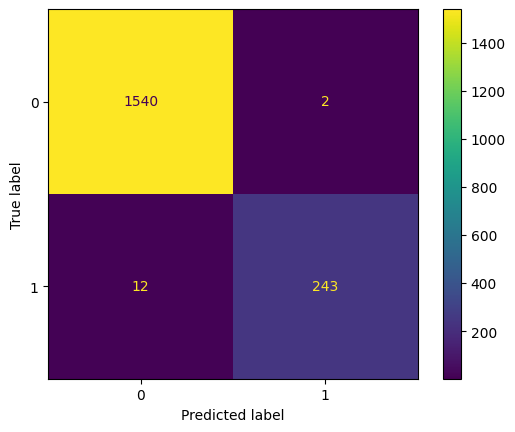

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1542
           1       0.99      0.95      0.97       255

    accuracy                           0.99      1797
   macro avg       0.99      0.98      0.98      1797
weighted avg       0.99      0.99      0.99      1797


Métricas de avaliação de teste:
[[172   0]
 [  4  24]]


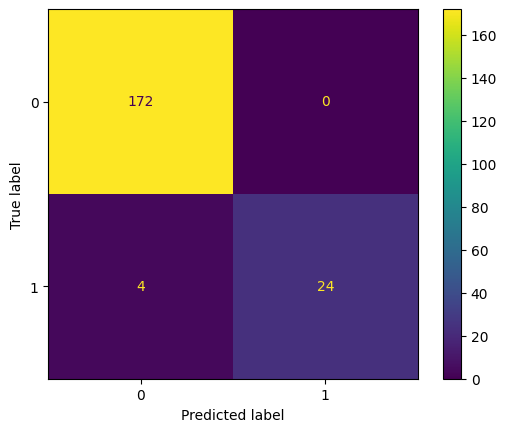

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       172
           1       1.00      0.86      0.92        28

    accuracy                           0.98       200
   macro avg       0.99      0.93      0.96       200
weighted avg       0.98      0.98      0.98       200



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train_ob = pipe.predict(X_train_ob)

print(confusion_matrix(y_train_ob, y_pred_train_ob))

ConfusionMatrixDisplay.from_predictions(y_train_ob, y_pred_train_ob)
plt.show()

print(classification_report(y_train_ob, y_pred_train_ob))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test_ob = pipe.predict(X_test_ob)

print(confusion_matrix(y_test_ob, y_pred_test_ob))

ConfusionMatrixDisplay.from_predictions(y_test_ob, y_pred_test_ob)
plt.show()

print(classification_report(y_test_ob, y_pred_test_ob))

**Já conseguimos equilibrar mais com otimização Bayesiana:**

In [ ]:
probas_y_pred_test_ob = pipe.predict_proba(X_test_ob)

In [ ]:
tabela_xgbc_ob = pd.DataFrame()

In [ ]:
y_test_ob.shape, y_pred_test_ob.shape

((200,), (200,))

In [ ]:
tabela_xgbc_ob["Amostra existente"] = y_test_ob

In [ ]:
tabela_xgbc_ob["Predição"] = y_pred_test_ob

In [ ]:
tabela_xgbc_ob

,Amostra existente,Predição
894,0,0
1752,0,0
725,0,0
1010,0,0
1769,0,0
...,...,...
665,0,0
242,0,0
1027,0,0
1697,0,0


Salvando a tabela

In [ ]:
tabela_xgbc_ob.to_csv("16-inadimplência_xgbc_ob.csv")

Salvando o estimador...

In [ ]:
import joblib

In [ ]:
joblib.dump(pipe, 'xgbc_modelo_ob.pkl')

['xgbc_modelo_ob.pkl']

In [ ]:
xgbc_modelo_ob = joblib.load('xgbc_modelo_ob.pkl')



---



---



---



#**INTERPRETABILIDADE DO MODELO GLOBALMENTE**

**Separar em features e target...**

In [ ]:
X = df.drop(columns=["i#clientid", "c#default"])
y = df["c#default"]

#Coloquei 90% para os dados de treino, semelhante ao KNN, pois há poucos dados. E estou usando o parâmetro para estratificar, pois os dados do target não estão balançeados.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13, stratify=y)

In [ ]:
xgbc_shap = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

In [ ]:
y_train = np.nan_to_num(y_train)
X_train = np.nan_to_num(X_train)

In [ ]:
xgbc_shap.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [ ]:
!pip install shap
import shap

In [ ]:
explainer = shap.TreeExplainer(xgbc_shap, X_train)

In [ ]:
shap_vals = explainer.shap_values(X_train)

In [ ]:
inadim = df["c#default"].unique()
print(f"{inadim}")

[0 1]


**Features que mais impactaram na escolha durante a geração do predict:**

In [ ]:
df.head(2)

,i#clientid,income,age,loan,c#default
0,1,1.453898,1.336861,1.201907,0
1,2,-0.762398,0.536639,0.695744,0


**A idade do cliente e o valor do empréstimo foram o que mais pesaram na predição. Supreendemente não foi a renda do cliente.**

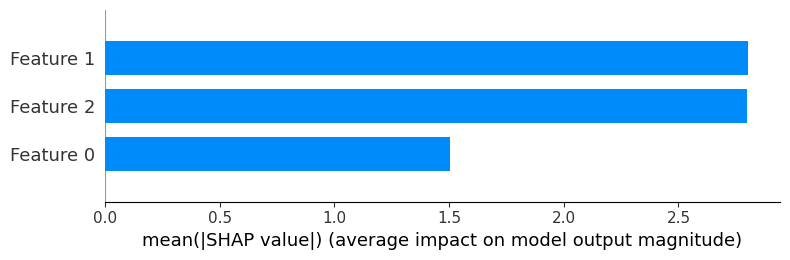

In [ ]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")

#**KerasClassifier**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install scikeras

In [ ]:
import tensorflow as tf
from keras import backend as k
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

In [ ]:
df.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,i#clientid,income,age,loan,c#default
0,1,1.453898,1.336861,1.201907,0
1,2,-0.762398,0.536639,0.695744,0
2,3,0.836733,1.637207,1.173812,0
3,4,-0.183244,0.362998,0.544366,0
4,5,1.509532,-1.631534,1.419754,1


In [ ]:
y_train = np.nan_to_num(y_train)
X_train = np.nan_to_num(X_train)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


**Dividindo os dados em target e features e aplicando a divisão de dados de treino e dados de teste.**

**Construino a rede...**

In [ ]:
X = dataset.drop(columns=["i#clientid", "c#default"])
y = dataset["c#default"]

#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    k.clear_session()
    rn = Sequential([
               #1ª camada oculta
               tf.keras.layers.Dense(units=2, activation = "relu", kernel_initializer = "random_uniform", input_dim=3), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
               #2ª camada oculta
               tf.keras.layers.Dense(units=2, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2), #Dropout = % de colunas zeradas para não dar overfitting! Recomendável entre 0.2 e 0.3
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'sigmoid')])
    

    rn.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ['binary_accuracy'])


    return rn

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
print(X_train.shape, y_train.shape)

(1797, 3) (1797,)


In [ ]:
rn = KerasClassifier(model=criarRede)
#============================================================================================
optimizers = ['adam']
init = ['uniform']
epochs = [1000]
batches = [20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, model__init=init)

#================================================================================
grid_search = GridSearchCV(estimator=rn,
                           param_grid=param_grid,
                           scoring="accuracy",
                           cv=10)

grid_search = grid_search.fit(X_train, y_train)

**Salvar o modelo:**

In [ ]:
import pickle

In [ ]:
with open("grid_search.pkl", "wb") as f:
    pickle.dump(grid_search, f)

In [ ]:
with open("grid_search.pkl", "rb") as f:
    
    grid_search = pickle.load(f)

In [ ]:
grid_search.best_params_

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'batch_size': 20,
 'epochs': 1000,
 'model__init': 'uniform',
 'optimizer': 'adam'}

**Score:**

In [ ]:
print(f"O melhor score foi de {(grid_search.best_score_)*100:.2f}%")

O melhor score foi de 88.93%


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Superamos o XGBoost e Otimização Bayesiana

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Métricas de avaliação de treino:
90/90 [==============================] - 0s 2ms/step
[[1542    0]
 [ 255    0]]


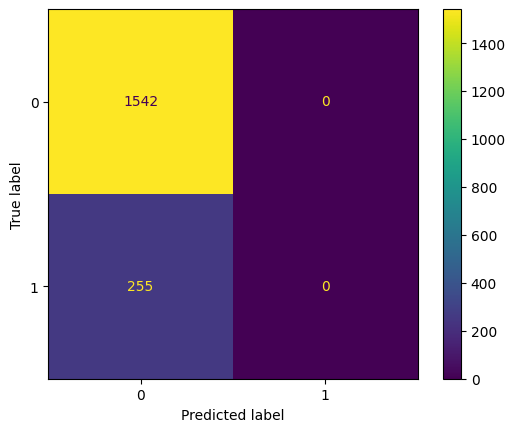

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1542
           1       0.00      0.00      0.00       255

    accuracy                           0.86      1797
   macro avg       0.43      0.50      0.46      1797
weighted avg       0.74      0.86      0.79      1797


Métricas de avaliação de teste:
10/10 [==============================] - 0s 1ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[172   0]
 [ 28   0]]


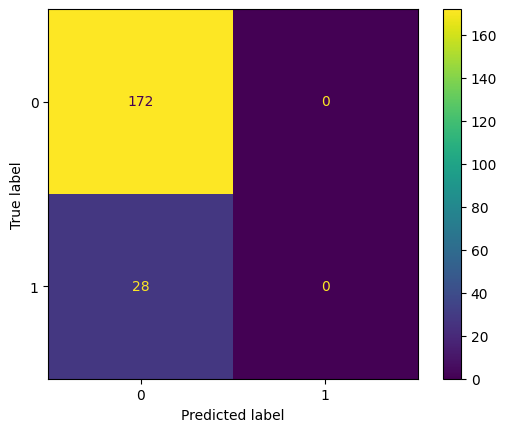

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       172
           1       0.00      0.00      0.00        28

    accuracy                           0.86       200
   macro avg       0.43      0.50      0.46       200
weighted avg       0.74      0.86      0.80       200



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = grid_search.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_search.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test));

In [ ]:
tabela = pd.DataFrame()
tabela["y real"] = y_test
tabela["y preditivo"] = y_pred_test
tabela

,y real,y preditivo
80,0,1
157,1,1
65,1,1
489,1,1
804,1,1
...,...,...
19,1,1
208,1,0
627,0,1
357,0,1


Salvando a tabela...

In [ ]:
tabela.to_csv("tabela_comparação.csv")

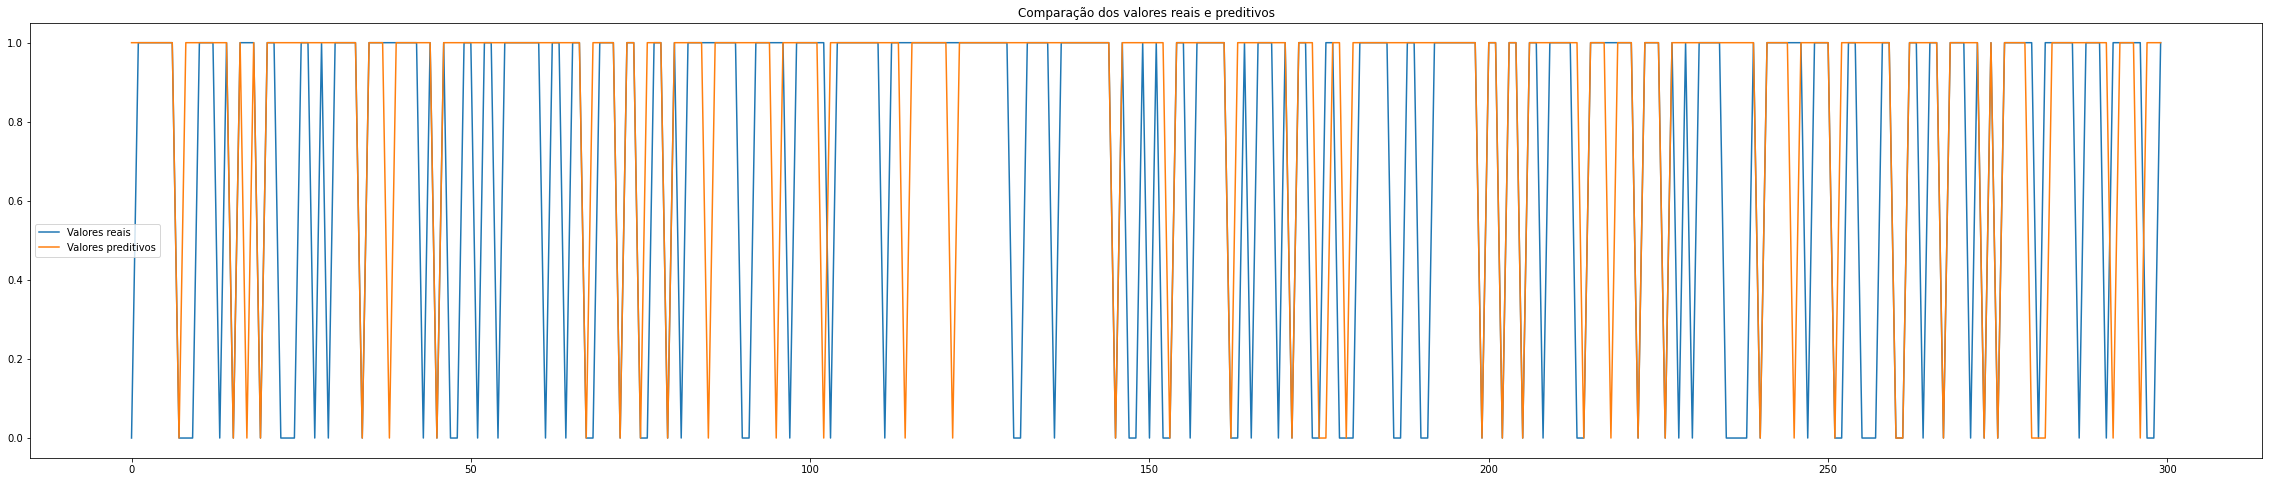

In [ ]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores reais")
plt.plot(x_ax, y_pred_test, label="Valores preditivos")
plt.title("Comparação dos valores reais e preditivos")
plt.legend()
plt.show();